# Trump's Twitter EDA and Sentiment Analysis

This project uses Twitter's API in order to analyze the 45th President's tweets. 

The first phase of this project uses pandas to import/clean data and make some insights into what device the data comes from and what time Trump's tweets arrive at.

The second phase uses VADER (Valence Aware Dictionary and Sentiment Reasoner). VADER lexicon is used to analyze the sentiment of the tweets. It is a rule-based sentiment analysis tool specifically for common social media language. This allows assignment of a numerical polarity value to individual words and emoji (see VADER section of notebook). In other words, this allows the project to measure the polarization of Trump's tweets.  
 
The analysis of this project can be used for any type of text sentiment analysis. Possible applications may be for measuring a youtube channel's comment polarization or for a product review sentiment analysis.
 
NOTE: This is meant to be a fun project, meant to showcase data and not make a political statement. 

In [1]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import json
from pathlib import Path
from pprint import pprint

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

In [2]:
!pip install tweepy

You should consider upgrading via the 'c:\users\ted kumagai\appdata\local\programs\python\python36\python.exe -m pip install --upgrade pip' command.


# Phase I: EDA

# Twitter API: Downloading Recent Tweets

Here the project's twitter data is downloaded using the Twitter API. 

In order to do this:

1. Create a Twitter Account.
2. Add a phone number in acount settings.
3. Create a twitter developer account.
4. Create an application on the developer account page. 
5. Find Consumer Key and Secret.
6. On the same page, create Access Token and record both the Access Token and Secret. 
7. Create a keys.json file and insert Token information.

In [3]:
import json
key_file = 'keys.json'
# Loading your keys from keys.json
with open(key_file) as f:
    keys = json.load(f)

This cell test Twitter authentication.

In [4]:
import tweepy
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

Your username is: LifeisthePath


In [5]:
def load_keys(path):
    """Loads Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
        key values."""
    
    import json
    with open(path, 'r') as e:
        return json.load(e)
    
    

def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }

    Returns:
        list: A list of Dictonary objects, each representing one tweet."""
    import tweepy
    import json
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    
    return [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name, 
                                             tweet_mode='extended').items()]

def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.
    
    Args:
        tweets (list): A list of tweet objects (of type Dictionary) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
    import json
    with open(path, "w") as e:        
        json.dump(tweets, e)
        

def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Dictionary) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
    import json
    with open(path, "w") as e:        
        json.dump(tweets, e)

def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    import json
    # Re-loading the json file:
    with open(path, "rb") as e:
        return json.load(e)

        
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """
    save_path = user_account_name+"_recent_tweets.json"
    
    if not Path(user_account_name+"_recent_tweets.json").is_file():
        save_tweets(download_recent_tweets_by_user(user_account_name, load_keys(keys_path)), save_path)
    return load_tweets(save_path)

When normally working, the last 3000 tweets from "@realdonaldtrump" are collected below:

In [6]:
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 3215


In [7]:
# Number of the month of the oldest tweet (e.g. 1 for January)
oldest_month = 8 #(August) 

# YOUR CODE HERE
trump_tweets[-1]
    

{'created_at': 'Sun May 10 19:21:23 +0000 2020',
 'id': 1259564206841626628,
 'id_str': '1259564206841626628',
 'full_text': 'RT @GreggJarrett: Steele Lawsuit Reveals ‘Most Direct Link’ Between Russia Collusion, Clinton and Obama White House https://t.co/AVUiCxQPqZ',
 'truncated': False,
 'display_text_range': [0, 139],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'GreggJarrett',
    'name': 'Gregg Jarrett',
    'id': 21536398,
    'id_str': '21536398',
    'indices': [3, 16]}],
  'urls': [{'url': 'https://t.co/AVUiCxQPqZ',
    'expanded_url': 'https://gjarr.it/3d6NRTW',
    'display_url': 'gjarr.it/3d6NRTW',
    'indices': [116, 139]}]},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 25073877,
  'id_str': '25073877',
  

In [8]:
trump_tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

Also, older trump tweets are not held on Public API's. Here, I load old_trump_tweets from an uploaded file of Trump's older tweets. 

In [9]:
file_name = 'old_trump_tweets.json.zip'

my_zip = zipfile.ZipFile(file_name, 'r')
with my_zip.open("old_trump_tweets.json", "r") as f:
    old_trump_tweets = json.load(f)


print(old_trump_tweets[0])


{'created_at': 'Wed Oct 12 14:00:48 +0000 2016', 'id': 786204978629185536, 'id_str': '786204978629185536', 'text': 'PAY TO PLAY POLITICS. \n#CrookedHillary https://t.co/wjsl8ITVvk', 'truncated': False, 'entities': {'hashtags': [{'text': 'CrookedHillary', 'indices': [23, 38]}], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 786204885318561792, 'id_str': '786204885318561792', 'indices': [39, 62], 'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/786204885318561792/pu/img/XqMoixLm83FzkAbn.jpg', 'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/786204885318561792/pu/img/XqMoixLm83FzkAbn.jpg', 'url': 'https://t.co/wjsl8ITVvk', 'display_url': 'pic.twitter.com/wjsl8ITVvk', 'expanded_url': 'https://twitter.com/realDonaldTrump/status/786204978629185536/video/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 600, 'h': 338, 'resize': 'fit'}, 'small': {'w': 340, 'h': 191, 'resize': 'fit'}, 'large': {'w': 1024, 'h': 576,

In [10]:
old_trump_tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

# Data Wrangling

Here, a DataFrame called 'trump' with tweet ID set to each tweet is created with these columns:

- `time`: The time the tweet was created encoded as a datetime object. (Use `pd.to_datetime` to encode the timestamp.)
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet. 

Lets start with merging the older tweets with more recent ones:

In [11]:
unique_ids = []
all_tweets = []

#id of every tweet is unique
for elem in old_trump_tweets:
    unique_ids.append(elem['id'])

for i in trump_tweets:
    if i['id'] in unique_ids:
        continue
    else:
        all_tweets.append(i)
        unique_ids.append(i['id'])
        
        
all_tweets += old_trump_tweets


In [12]:
data = {
        'time': [pd.to_datetime(t['created_at']) for t in all_tweets], 
        'source': [t['source'] for t in all_tweets], 
        'text': [t['text'] if 'text' in t else t['full_text'] for t in all_tweets], 
        'retweet_count': [t['retweet_count'] for t in all_tweets]
            }

index = [t['id'] for t in all_tweets]
trump = pd.DataFrame(data=data, index=index)

trump.sort_index().head()

,time,source,text,retweet_count
690171032150237184,2016-01-21 13:56:11+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059
690171403388104704,2016-01-21 13:57:39+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339
690173226341691392,2016-01-21 14:04:54+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006
690176882055114758,2016-01-21 14:19:26+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266
690180284189310976,2016-01-21 14:32:57+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886


# Tweet Sources

Here the project explores what devices Trump tweets come from. 

First the source field, which show how much Trump's tweet-content comes from Twitter for iPhone, Twitter Media Studio, Twitter Web App, Twitter for Android, Twitter Web Client, Media Studio, Twitter for IPad, Instagram, Mobile Web, Twitter Ads and Periscope:

In [13]:
trump['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
       '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>'],
      dtype=object)

In [14]:
## Uncomment and complete
trump['source'] = trump['source'].str.replace("<[^>]*>", '')
trump['source'].unique()

array(['Twitter for iPhone', 'Twitter Media Studio', 'Twitter Web App',
       'Twitter for Android', 'Twitter Web Client', 'Media Studio',
       'Twitter for iPad', 'Instagram', 'Mobile Web (M5)', 'Twitter Ads',
       'Periscope'], dtype=object)

In [15]:
from datetime import datetime
ELEC_DATE = datetime(2016, 11, 8)
INAUG_DATE = datetime(2017, 1, 20)


Text(0, 0.5, 'Number of Tweets')

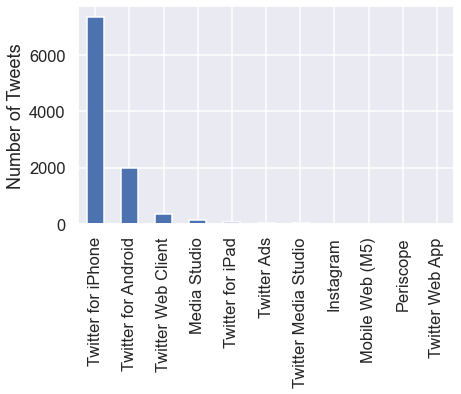

In [16]:
trump['source'].value_counts().plot(kind="bar")
plt.ylabel("Number of Tweets")

Lets see if there is anything that can be garnered using the time data. 

First, lets see if the timezones are synced between all devices:

In [17]:
for t in trump_tweets[0:3]:
    print(t['created_at'])

Sun Aug 16 18:41:50 +0000 2020
Sun Aug 16 18:38:51 +0000 2020
Sun Aug 16 18:37:38 +0000 2020


They are synced, but to Pacific time. Since Trump is on the east coast, lets convert the time data to East Coast time. 

In [18]:
trump['est_time'] = (
    trump['time'] # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)

trump.head()

,time,source,text,retweet_count,est_time
1295068266843582465,2020-08-16 18:41:50+00:00,Twitter for iPhone,RT @bennyjohnson: What if people talked like @JOEBIDEN?\n\nAwkward... https://t.co/POpBPnRZSS,29381,2020-08-16 13:41:50-05:00
1295067517283598336,2020-08-16 18:38:51+00:00,Twitter for iPhone,Thank you Franklin! https://t.co/ZwpwcS2k2B,9011,2020-08-16 13:38:51-05:00
1295067207618244610,2020-08-16 18:37:38+00:00,Twitter for iPhone,Thank you James! https://t.co/cKiKlAXHqI,11044,2020-08-16 13:37:38-05:00
1295067052508696576,2020-08-16 18:37:01+00:00,Twitter for iPhone,"RT @EricTrump: Robert Trump was an incredible man - strong, kind and loyal to the core. Anyone who encountered him felt his warmth immediat…",22936,2020-08-16 13:37:01-05:00
1295066300419538946,2020-08-16 18:34:01+00:00,Twitter for iPhone,"RT @ChristieC733: I’m hearing some Republicans, pundits say we should “move on” from the #MullerReport in order to heal the nation...\n\nI di…",21018,2020-08-16 13:34:01-05:00


Now adding a 'hour' column to the table using the equation: 

$$
\text{hour} + \frac{\text{minute}}{60} + \frac{\text{second}}{60^2}
$$


In [19]:
trump['hour'] = trump['est_time'].dt.hour + trump['est_time'].dt.minute/60 + trump['est_time'].dt.second/(60*60)
trump.loc[690171032150237184]['hour']

8.936388888888889

# Plotting

The seaborn distplot funciton is used here to examine the distribution over hours of the day in EST that trump tweets on his Android and Iphone devices:

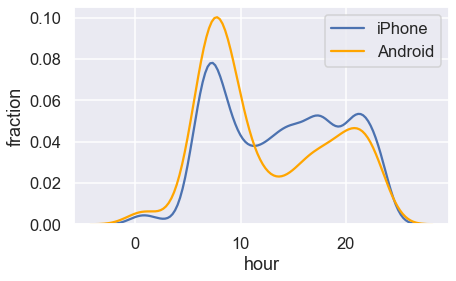

In [20]:
x = sns.distplot(trump[trump['source'] == 'Twitter for iPhone']['hour'], hist = False, kde=True, rug=False, color = 'b', label = 'iPhone' )
y = sns.distplot(trump[trump['source'] == 'Twitter for Android']['hour'], hist = False, kde=True, rug=False, color = 'orange', label = 'Android' )

plt.xlabel("hour")
plt.ylabel("fraction")

plt.legend()

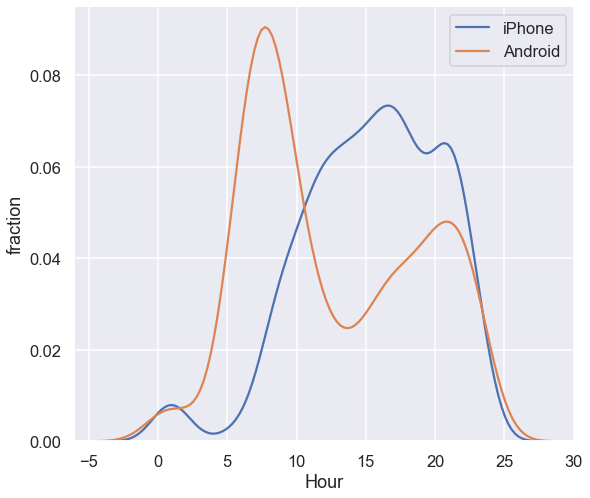

In [21]:
x = trump.loc[trump['source'] == 'Twitter for iPhone']
y = trump.loc[trump['source'] == 'Twitter for Android']

x_2016 = x.loc[x['est_time'].dt.year == 2016]
y_2016 = y.loc[y['est_time'].dt.year == 2016]

plt.figure(figsize=(8, 8))

sns.distplot(x_2016['hour'], hist=False, label = 'iPhone')
sns.distplot(y_2016['hour'], hist=False, label = 'Android')

plt.xlabel("Hour")
plt.ylabel("fraction")

plt.show()

According to [this Verge article](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android), Donald Trump switched from an Android to an iPhone sometime in March 2017. Lets check this out by looking at Trump's 2016 tweets:

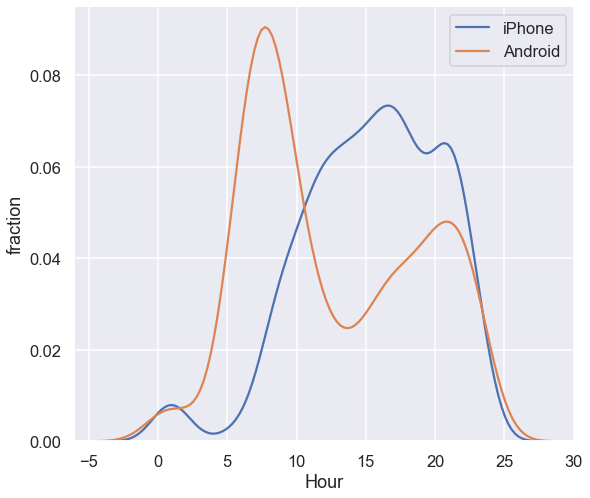

In [22]:
x = trump.loc[trump['source'] == 'Twitter for iPhone']
y = trump.loc[trump['source'] == 'Twitter for Android']

x_2016 = x.loc[x['est_time'].dt.year == 2016]
y_2016 = y.loc[y['est_time'].dt.year == 2016]

plt.figure(figsize=(8, 8))

sns.distplot(x_2016['hour'], hist=False, label = 'iPhone')
sns.distplot(y_2016['hour'], hist=False, label = 'Android')

plt.xlabel("Hour")
plt.ylabel("fraction")

plt.show()

This seems plausible with the following thinking. Trump may prefer to tweet before and after work, hence around 6 am and around 8pm. His staff may continously be tweeting over a workday schedule 9am to about 8pm est time. Again, it the above theory is plausble based on the above graph. 


Lets compare Trump's iPhone usage to his Android usage. First, in order to plot the data as a distribution, the dates need to bge convereted to a fractional year:

In [23]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length


trump['year'] = trump['time'].apply(year_fraction)

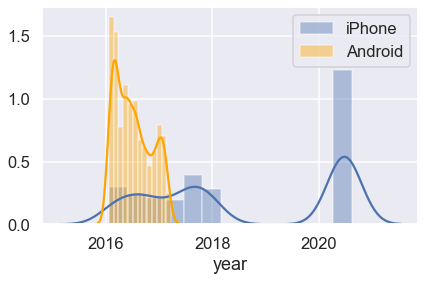

In [24]:
x = sns.distplot(trump[trump['source'] == 'Twitter for iPhone']['year'], hist = True, kde=True, rug=False, color = 'b', label = 'iPhone' )
y = sns.distplot(trump[trump['source'] == 'Twitter for Android']['year'], hist = True, kde=True, rug=False, color = 'orange', label = 'Android' )
#bike[bike['weekday']==i]['prop_casual'], bike[bike['weekday']==i]['temp']*41

#plt.axis([0,8000, 0, 0.0008])
plt.xlabel("year")

plt.legend()

Okay so there is a problem here, I originally did this project in 2019. It's 2020 now, so the data I can scrape has missing data between 2018 and 2020. The rest of the analysis does not hinge on this gap of data. When possible, I will find missing data to fill the missing gap.

Otherwise, here is the original resulting graph: 

<img src="source_years.png" width="600px" />



# Phase II: Sentiment Analysis

As mentioned in the introduction, it turns out that words in Trump's tweets can be used to calculate a measure of the sentiment. For example, the sentence "Make America Great Again!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. Some words words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

Again, VADER lexicon is used to analyze the sentiment of the tweets. It is a rule-based sentiment analysis tool specifically for common social media language. It even accounts for emoji:  

In [25]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



As shown, the first column of the lexicon is the token, or the word itself. The second column is the word's polarit, or how positive / negative it is.

Here, the lexicon is appended to a DataFrame called 'sent':


In [26]:
sent = (pd.read_csv("vader_lexicon.txt", sep ='\t', header = None).
        loc[:,0:1].set_index(0).
        rename({1:'polarity'}, axis='columns')
       )
        
sent.head()

,polarity
0,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


Now to set all letters to lowercase since the lexicon is only lowercase. 

In [27]:
trump['text'] = trump['text'].str.lower()
#trump.index[(trump.values=='working hard to get the olympics for the united states (l.a.). stay tuned!').any(0)].tolist()
trump['text'].loc[884740553040175104]

'working hard to get the olympics for the united states (l.a.). stay tuned!'

Since punctuation is not accounted for in the Lexicon, all punctuation is removed and replaced with a whitespace. 

In [28]:
#regex is used here
punct_re = r'[^\w\s]'
trump['no_punc'] = trump['text'].str.replace(punct_re, ' ')

# Tidy Format

Tidy format is a format that makes sentiments easier to calculate. For more, see the [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) page. 

In [29]:
tidy_format = (
    trump['no_punc']
     .str.split(expand=True)
     .stack()
     .reset_index()
     .iloc[:,0:3]
     .set_index('level_0') 
    )

tidy_format.columns = ['num', 'word']
del tidy_format.index.name

tidy_format.head()

,num,word
1295068266843582465,0,rt
1295068266843582465,1,bennyjohnson
1295068266843582465,2,what
1295068266843582465,3,if
1295068266843582465,4,people


In [30]:
sent.head()

,polarity
0,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


Now, the `tidy_format` table can be joined with the lexicon table. The sum of the sentiment polarity of each word in the text of the tweet is called `polarity`: 

In [31]:
j = (
    pd.merge(tidy_format, sent, left_on='word', right_index=True)      
    

)

k = j.groupby(j.index).polarity.agg({'polarity': np.sum})

trump['polarity'] = k
trump = trump.fillna(value=0)
trump.loc[744355251365511169, 'polarity']


c:\users\ted kumagai\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  import sys


0.0

# EDA

Lets take a look at these tweets first by looking at the most postitive and negative Trump tweets. 

In [32]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   today, it was my great honor to proudly accept the endorsement of the @nycpba! i have deeply and profoundly admired the brave men and women of the #nypd for my entire life. new york’s finest are truly the best of the best — i will never let you down! #maga https://t.co/o1l5kax34v

   i am a big fan of drew brees. i think he’s truly one of the greatest quarterbacks, but he should not have taken back his original stance on honoring our magnificent american flag. old glory is to be revered, cherished, and flown high...

   today we celebrated the passage of landmark legislation that will preserve america’s majestic natural wonders, priceless historic treasures, grand national monuments, and glorious national parks. it was my great honor to sign the great american outdoors act into law! #hr1957 https://t.co/kxdgpidqh2

   congratulations to @ronnyjackson4tx on a big win against a tough and really good opponent. ronny will be a fantastic congressman - will represen

In [33]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   colin powell was a pathetic interview today on fake news cnn. in his time, he was weak &amp; gave away everything to everybody - so bad for the usa. also got the “weapons of mass destruction” totally wrong, and you know what that mistake cost us? sad! only negative questions asked.

   rarely has anybody deserved the death penalty more than the boston bomber, dzhokhar tsarnaev. the court agreed that this “was one of the worst domestic terrorist attacks since the 9/11 atrocities”. yet the appellate court tossed out the death sentence. so many lives lost....

   horrible and cowardly terrorist attack on innocent and defenseless worshipers in egypt. the world cannot tolerate terrorism, we must defeat them militarily and discredit the extremist ideology that forms the basis of their existence!

   because of mail-in ballots, 2020 will be the most rigged election in our nations history - unless this stupidity is ended. we voted during world war one &amp; world war 

# Plotting Distribution: New York Times vs. Fox

From plot, tweets with 'fox' seem more postivie than "nyt" as FOX graph is centered around 0 or +1 versus NYT graph centered around -3. Fox is more postive trend than NYT comments which are more negative. 

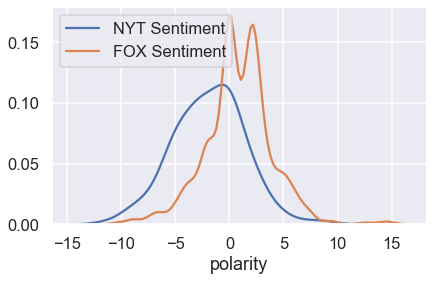

In [34]:
nyt = trump.loc[trump['no_punc'].str.contains('nyt')]
fox = trump.loc[trump['no_punc'].str.contains('fox')]

sns.distplot(nyt['polarity'], hist=False, label = 'NYT Sentiment')
sns.distplot(fox['polarity'], hist=False, label = 'FOX Sentiment')
plt.show()

# Engagement: What words lead to a greater number of retweets?

Here the top 20 most retweeted words are found. These words appear in at least 25 of Trump's tweets. 

In [35]:
top_20 = (tidy_format
        .join(trump['retweet_count'])
        .loc[:,['word', 'retweet_count']]
        .groupby('word')
        .filter(lambda i: len(i) >= 25)
        .groupby('word')
        .mean()
        .sort_values('retweet_count', ascending=False)
        .head(20)
            ) 
        
top_20.head(7)

,retweet_count
word,
anarchists,39024.441860
try,35764.264706
seattle,34074.440000
lowest,33994.406250
virus,31392.923077
cases,31338.285714
old,31220.925926


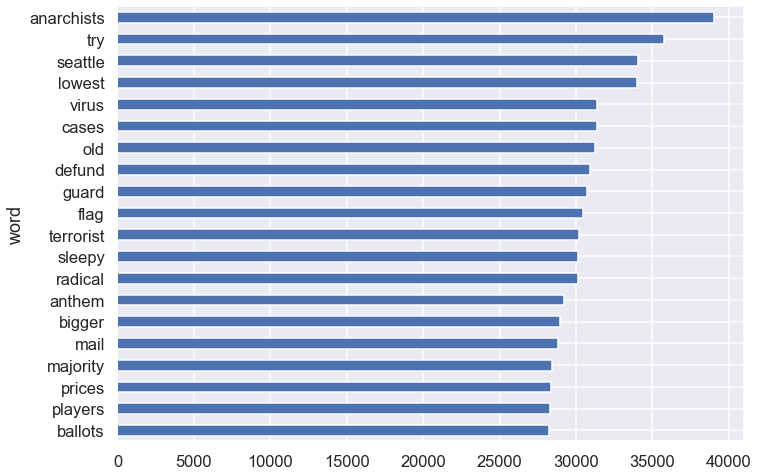

In [36]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8));

# Tweet Sentiment vs. Reweet Count

From graph below, there appears slight negative relationship between sentiment and retweet count. This is shown via the negative skew of the linear regression line. This is not a definite conclusion as correlation does not imply causation. This data, however, does is plausible enough to reinforce the notion between Tweet sentiment and Retweet Count.

The graph may be affected by outliers and how his number of followers increasing post presidency may be affecting this data. The data overall may be able to be skewed more properly via measing the ratio of retweets to the number of followers and averaging them over a timeframe.

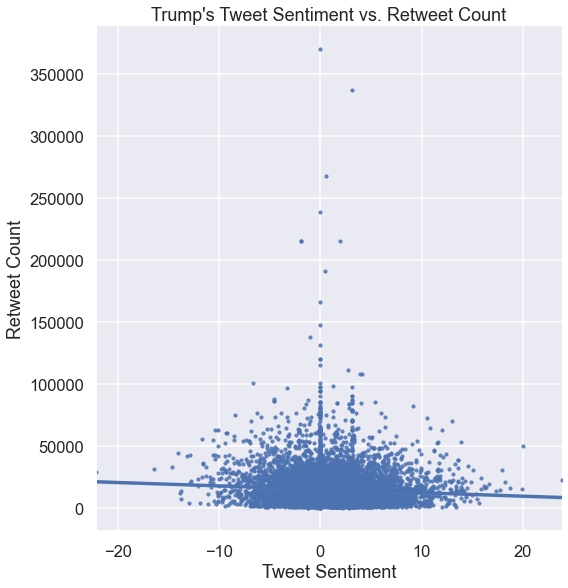

In [37]:
sns.lmplot(data=trump, x='polarity', y='retweet_count', scatter_kws={'s':10}, height=8 )

plt.title("Trump's Tweet Sentiment vs. Retweet Count")
plt.xlabel("Tweet Sentiment")
plt.ylabel("Retweet Count")

plt.show()

# Conclusion: 


This project was pretty fun to do. I enjoyed seeing how people's tweets can be measured in terms of polarization with the VADER lexicon. I also showed more data cleaning and graphing methods. The important thing to note is that although, through python, I can generate graphs and visuals; the data and graphs are just data and graphs. It is important that a person comes in and makes a story out of the data. This is why I think it is paramount to be able to document and explain your work in a easily communicable fashion. 

Thanks for taking a read!